## Assignment: Image recognition
- Alumno 1: Dakota Mellish
- Alumno 2: Javier Arteaga
- Alumno 3: Rodrigo Castanon

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/4oNHlRFEd71HXp4](https://drive.upm.es/s/4oNHlRFEd71HXp4)

In [1]:


     
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Set Working Directory

In [2]:
import os 

print(os.getcwd())

os.chdir('/kaggle')
print(os.getcwd())


base_dir='/kaggle/input/xview-recognition/xview_recognition/'

/kaggle/working
/kaggle


In [3]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [4]:
categories = {0: 'Cargo plane', 1: 'Helicopter', 2: 'Small car', 3: 'Bus', 4: 'Truck', 5: 'Motorboat', 6: 'Fishing vessel', 7: 'Dump truck', 8: 'Excavator', 9: 'Building', 10: 'Storage tank', 11: 'Shipping container'}

In [5]:
!pip install rasterio
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(base_dir+filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.1 MB/s eta 0:00:00:00:0100:01


#### Training
Design and train a ffNN to deal with the “xview_recognition” classification task.

In [6]:


import json
# Load database
json_file = base_dir+'/xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [7]:
import numpy as np

counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
print(counts)

{'Cargo plane': 635, 'Helicopter': 70, 'Small car': 4290, 'Bus': 2155, 'Truck': 2746, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 4689, 'Storage tank': 1469, 'Shipping container': 1523}


In [8]:
from sklearn.model_selection import train_test_split

anns_train, anns_valid = train_test_split(anns, test_size=0.1, random_state=1, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 19239
Number of validation images: 2138


### Model Create
Design model structure and shape 

In [9]:
# Load architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, add,Dropout, Activation, Flatten,LeakyReLU

from tensorflow.keras import Input


from numpy import random

## By default, the number of neurons is the same as the number of categories
def make_model(n_layers_dense,n_neurons,categories,input_shape,activation_list=None,activation_type=None,random_activation=None):
    model = Sequential()  
    model.add(Flatten(input_shape=input_shape))
    ## Pull common activation types from https://faroit.com/keras-docs/1.2.2/activations/
    activation_types=['relu','sigmoid','softmax','tanh','softplus','softsign','sigmoid','linear']
    for layer in range(0,n_layers_dense):
     
        if random_activation is None:
            if layer==n_layers_dense-1:
                model.add(Activation(activation_list[layer]))
                model.add(Dense(len(categories)))
            else:
                model.add(Dense(n_neurons))
        elif random_activation==True:
            rand_activation_idx=random.randint(low=0,high=len(activation_types))
            model.add(Activation(activation_types[rand_activation_idx]))
        
            model.add(Dense(n_neurons))
            if layer==n_layers_dense-1:
                model.add(Activation(activation_types[rand_activation_idx]))
                model.add(Dense(len(categories)))
    model.add(Activation('softmax'))
    return model




model_1=make_model(n_layers_dense=3,n_neurons=len(categories),input_shape=(224,224,3),activation_list=['relu','tanh','sigmoid','relu','linear'],categories=categories)

model_2=make_model(n_layers_dense=5,n_neurons=200,input_shape=(224,224,3),activation_list=['relu','tanh','sigmoid','relu','linear'],categories=categories)


model_3=make_model(n_layers_dense=5,n_neurons=1000,input_shape=(224,224,3),activation_list=['relu','tanh','sigmoid','relu','linear'],categories=categories)

model_4=make_model(n_layers_dense=8,n_neurons=1000,input_shape=(224,224,3),activation_list=['relu','tanh','sigmoid','relu','linear','sigmoid','softsign','tanh'],categories=categories)


# model.summary()







### Here we can experiment with the architecture and try different amounts of layers

# print('Load model')
# model = Sequential()
# ## This part will never change due to the input structure
# model.add(Flatten(input_shape=(224, 224, 3)))

# ## Here we can experiment between 
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Dense(len(categories)))
# model.add(Activation('softmax'))
# model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

learning_rates=[1e-3,1e-2,1e-1]

# Learning rate is changed to 0.001
opt_1 = Adam(learning_rate=learning_rates[1], beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
opt_2 = Adam(learning_rate=learning_rates[1], beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
opt_3 = Adam(learning_rate=learning_rates[1], beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
opt_4 = Adam(learning_rate=learning_rates[1], beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)

opt_2=SGD(learning_rate=learning_rates[1])
opt_3=RMSprop(learning_rate=learning_rates[1])



model_1.compile(optimizer=opt_1, loss='categorical_crossentropy', metrics=['accuracy'])
model_2.compile(optimizer=opt_2, loss='categorical_crossentropy', metrics=['accuracy'])
model_3.compile(optimizer=opt_3, loss='categorical_crossentropy', metrics=['accuracy'])
model_4.compile(optimizer=opt_4, loss='categorical_crossentropy', metrics=['accuracy'])



## Here we can experiment with a different optimizer such as Momentum, SGD, or RMSPROP as well as learning rate




In [17]:
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Callbacks
model_checkpoint_1 = ModelCheckpoint('/kaggle/working/model_1.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
model_checkpoint_2 = ModelCheckpoint('/kaggle/working/model_2.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
model_checkpoint_3 = ModelCheckpoint('/kaggle/working/model_3.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
model_checkpoint_4 = ModelCheckpoint('/kaggle/working/model_4.keras', monitor='val_accuracy', verbose=1, save_best_only=True)

reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks_1 = [model_checkpoint_1, reduce_lr, early_stop, terminate]
callbacks_2 = [model_checkpoint_2, reduce_lr, early_stop, terminate]
callbacks_3 = [model_checkpoint_3, reduce_lr, early_stop, terminate]
callbacks_4 = [model_checkpoint_4, reduce_lr, early_stop, terminate]

In [18]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [19]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]
# Generators
batch_size = 16
train_generator = generator_images(objs_train, batch_size, do_shuffle=True)
valid_generator = generator_images(objs_valid, batch_size, do_shuffle=False)

In [20]:
import math
import numpy as np

print('Training model')
epochs = 20
train_steps = math.ceil(len(objs_train)/batch_size)
valid_steps = math.ceil(len(objs_valid)/batch_size)
h_1 = model_1.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks_1, verbose=1)
h_2= model_2.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks_2, verbose=1)
h_3=model_3.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks_3, verbose=1)
h_4=model_4.fit(train_generator, steps_per_epoch=train_steps, validation_data=valid_generator, validation_steps=valid_steps, epochs=epochs, callbacks=callbacks_4, verbose=1)

# # Best validation model
# best_idx = int(np.argmax(h.history['val_accuracy']))
# best_value = np.max(h.history['val_accuracy'])
# print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model
Epoch 1/20
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2110 - loss: 2.1982
Epoch 1: val_accuracy improved from -inf to 0.23152, saving model to /kaggle/working/model_1.keras
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 105s 86ms/step - accuracy: 0.2110 - loss: 2.1982 - val_accuracy: 0.2315 - val_loss: 2.1899 - learning_rate: 0.0100
Epoch 2/20
1202/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2199 - loss: 2.1995
Epoch 2: val_accuracy did not improve from 0.23152
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 119s 99ms/step - accuracy: 0.2199 - loss: 2.1995 - val_accuracy: 0.2273 - val_loss: 2.2032 - learning_rate: 0.0100
Epoch 3/20
1202/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2120 - loss: 2.2058
Epoch 3: val_accuracy did not improve from 0.23152
1203/1203 ━━━━━━━━━━━━━━━━━━━━ 137s 114ms/step - accuracy: 0.2120 - loss: 2.2058 - val_accuracy: 0.1993 - val_loss: 2.2141 - learning_rate: 0.0100
Epoch 4/20
1202/1203 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2158 - l

#### Validation
Compute validation metrics.

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show(fig)

<ipython-input-21-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


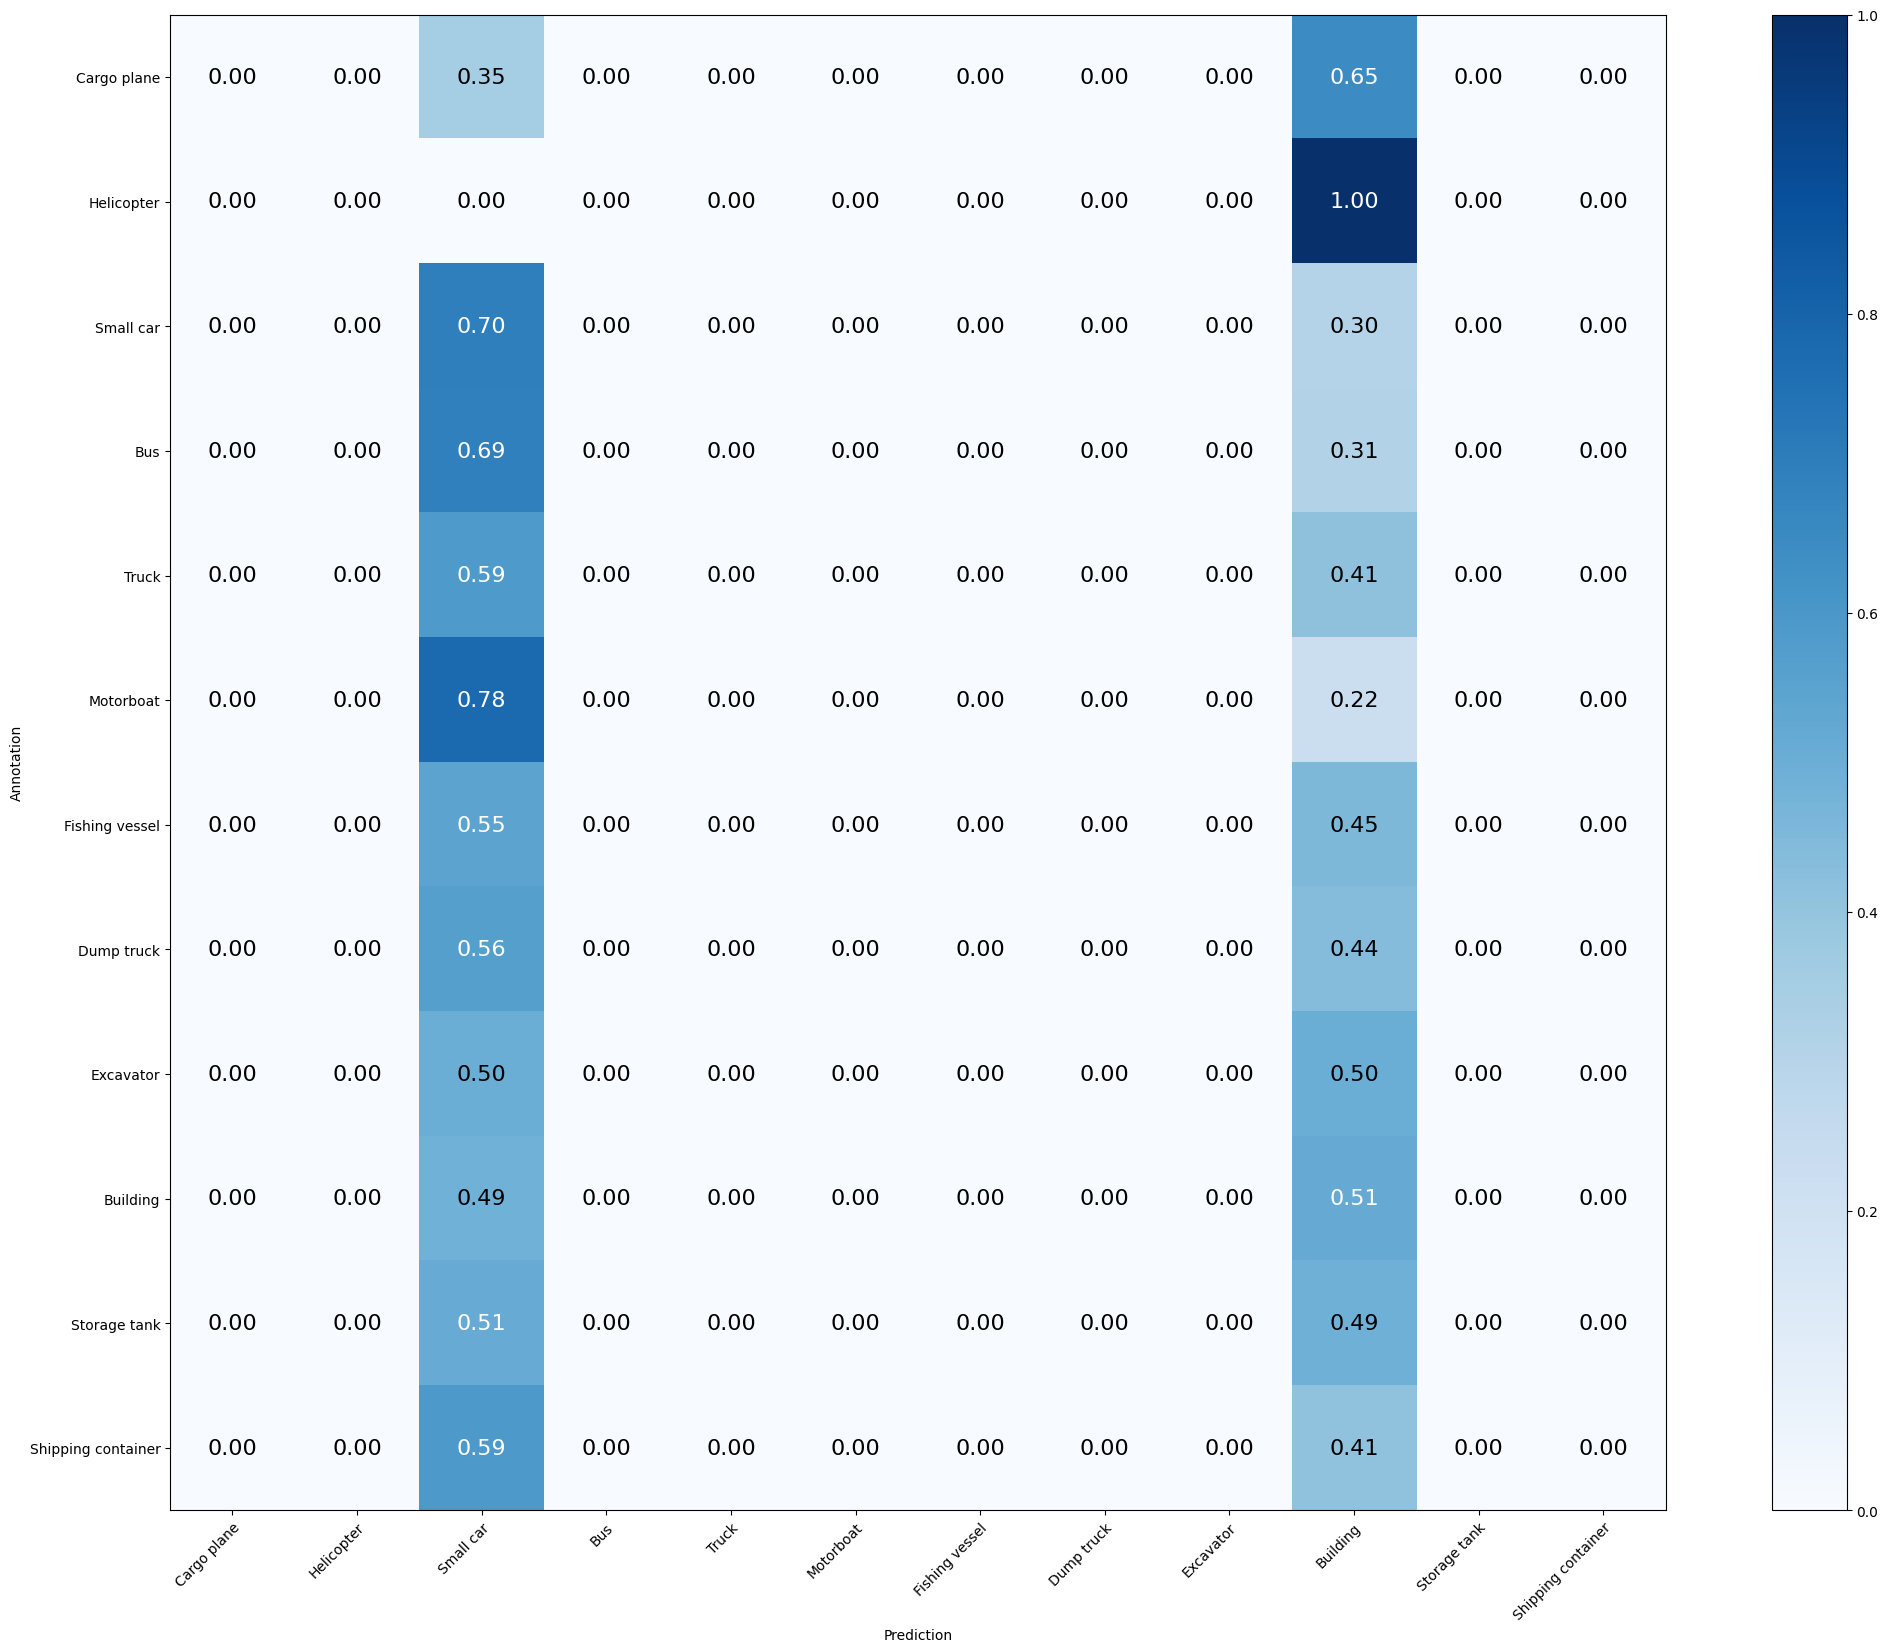

Mean Accuracy: 25.585%
Mean Recall: 10.078%
Mean Precision: 4.339%
> Cargo plane: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 69.524% Precision: 23.379% Specificity: 44.296% Dice: 34.991%
> Bus: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Truck: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Motorboat: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Fishing vessel: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Dump truck: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Excavator: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Building: Recall: 51.411% Precision: 28.684% Specificity: 61.389% Dice: 36.823%
> Storage tank: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Shipping container: Recall: 0.000% 

<ipython-input-21-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


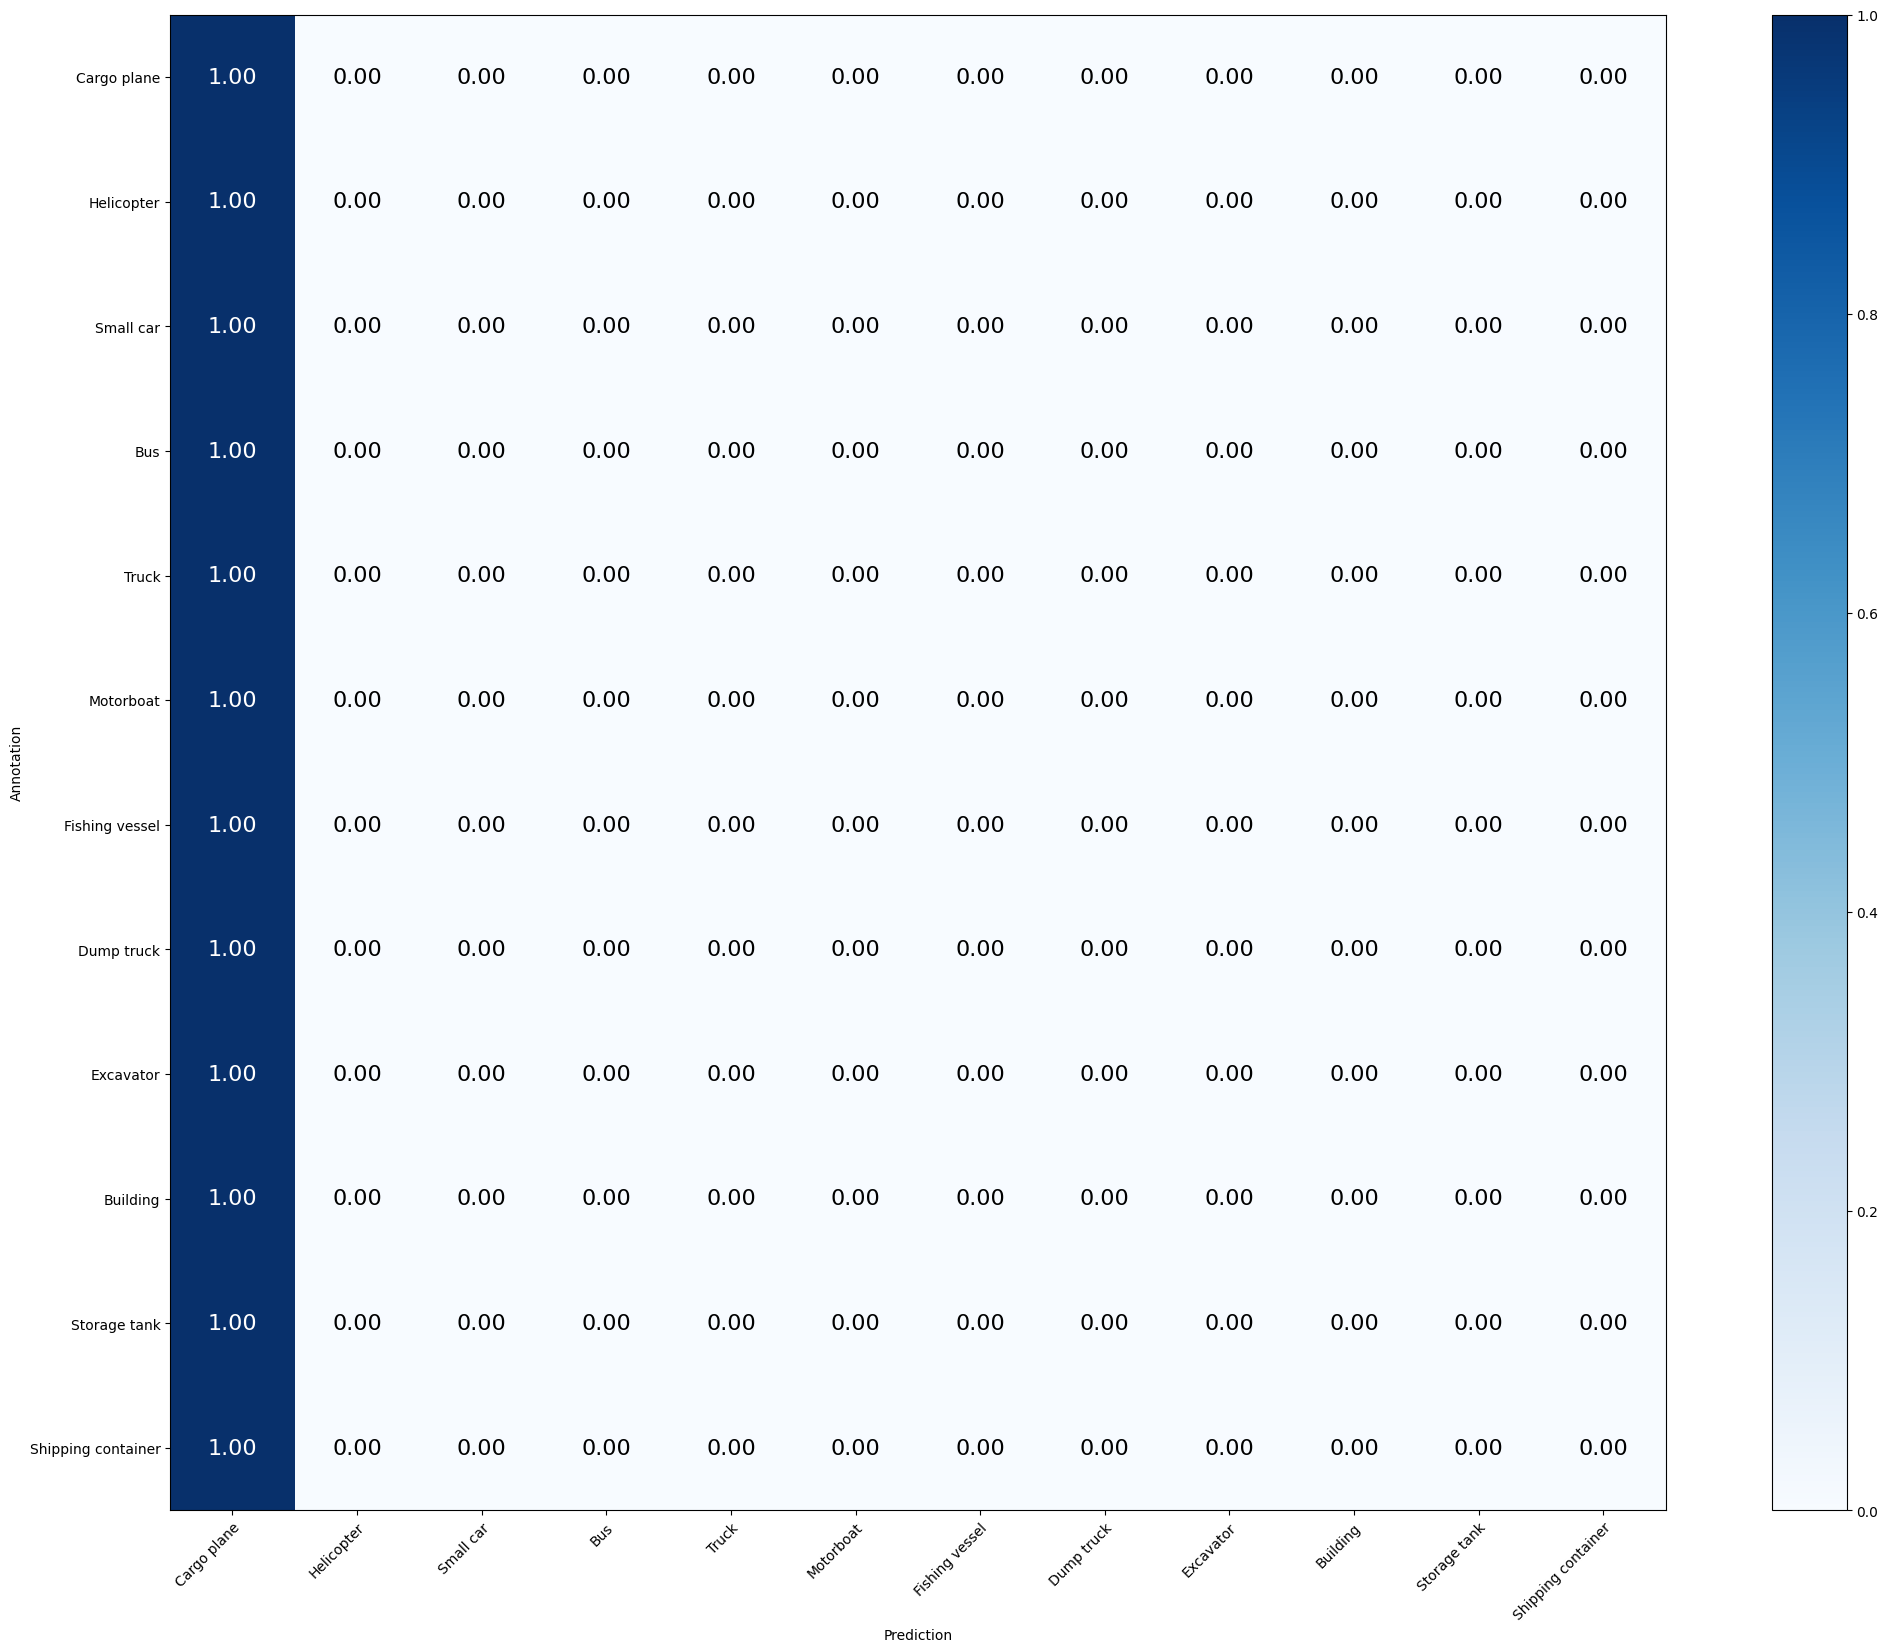

Mean Accuracy: 3.181%
Mean Recall: 8.333%
Mean Precision: 0.265%
> Cargo plane: Recall: 100.000% Precision: 3.181% Specificity: 0.000% Dice: 6.165%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Bus: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Truck: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Motorboat: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Fishing vessel: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Dump truck: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Excavator: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Building: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Storage tank: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Shipping container: Recall: 0.000% Precis

<ipython-input-21-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


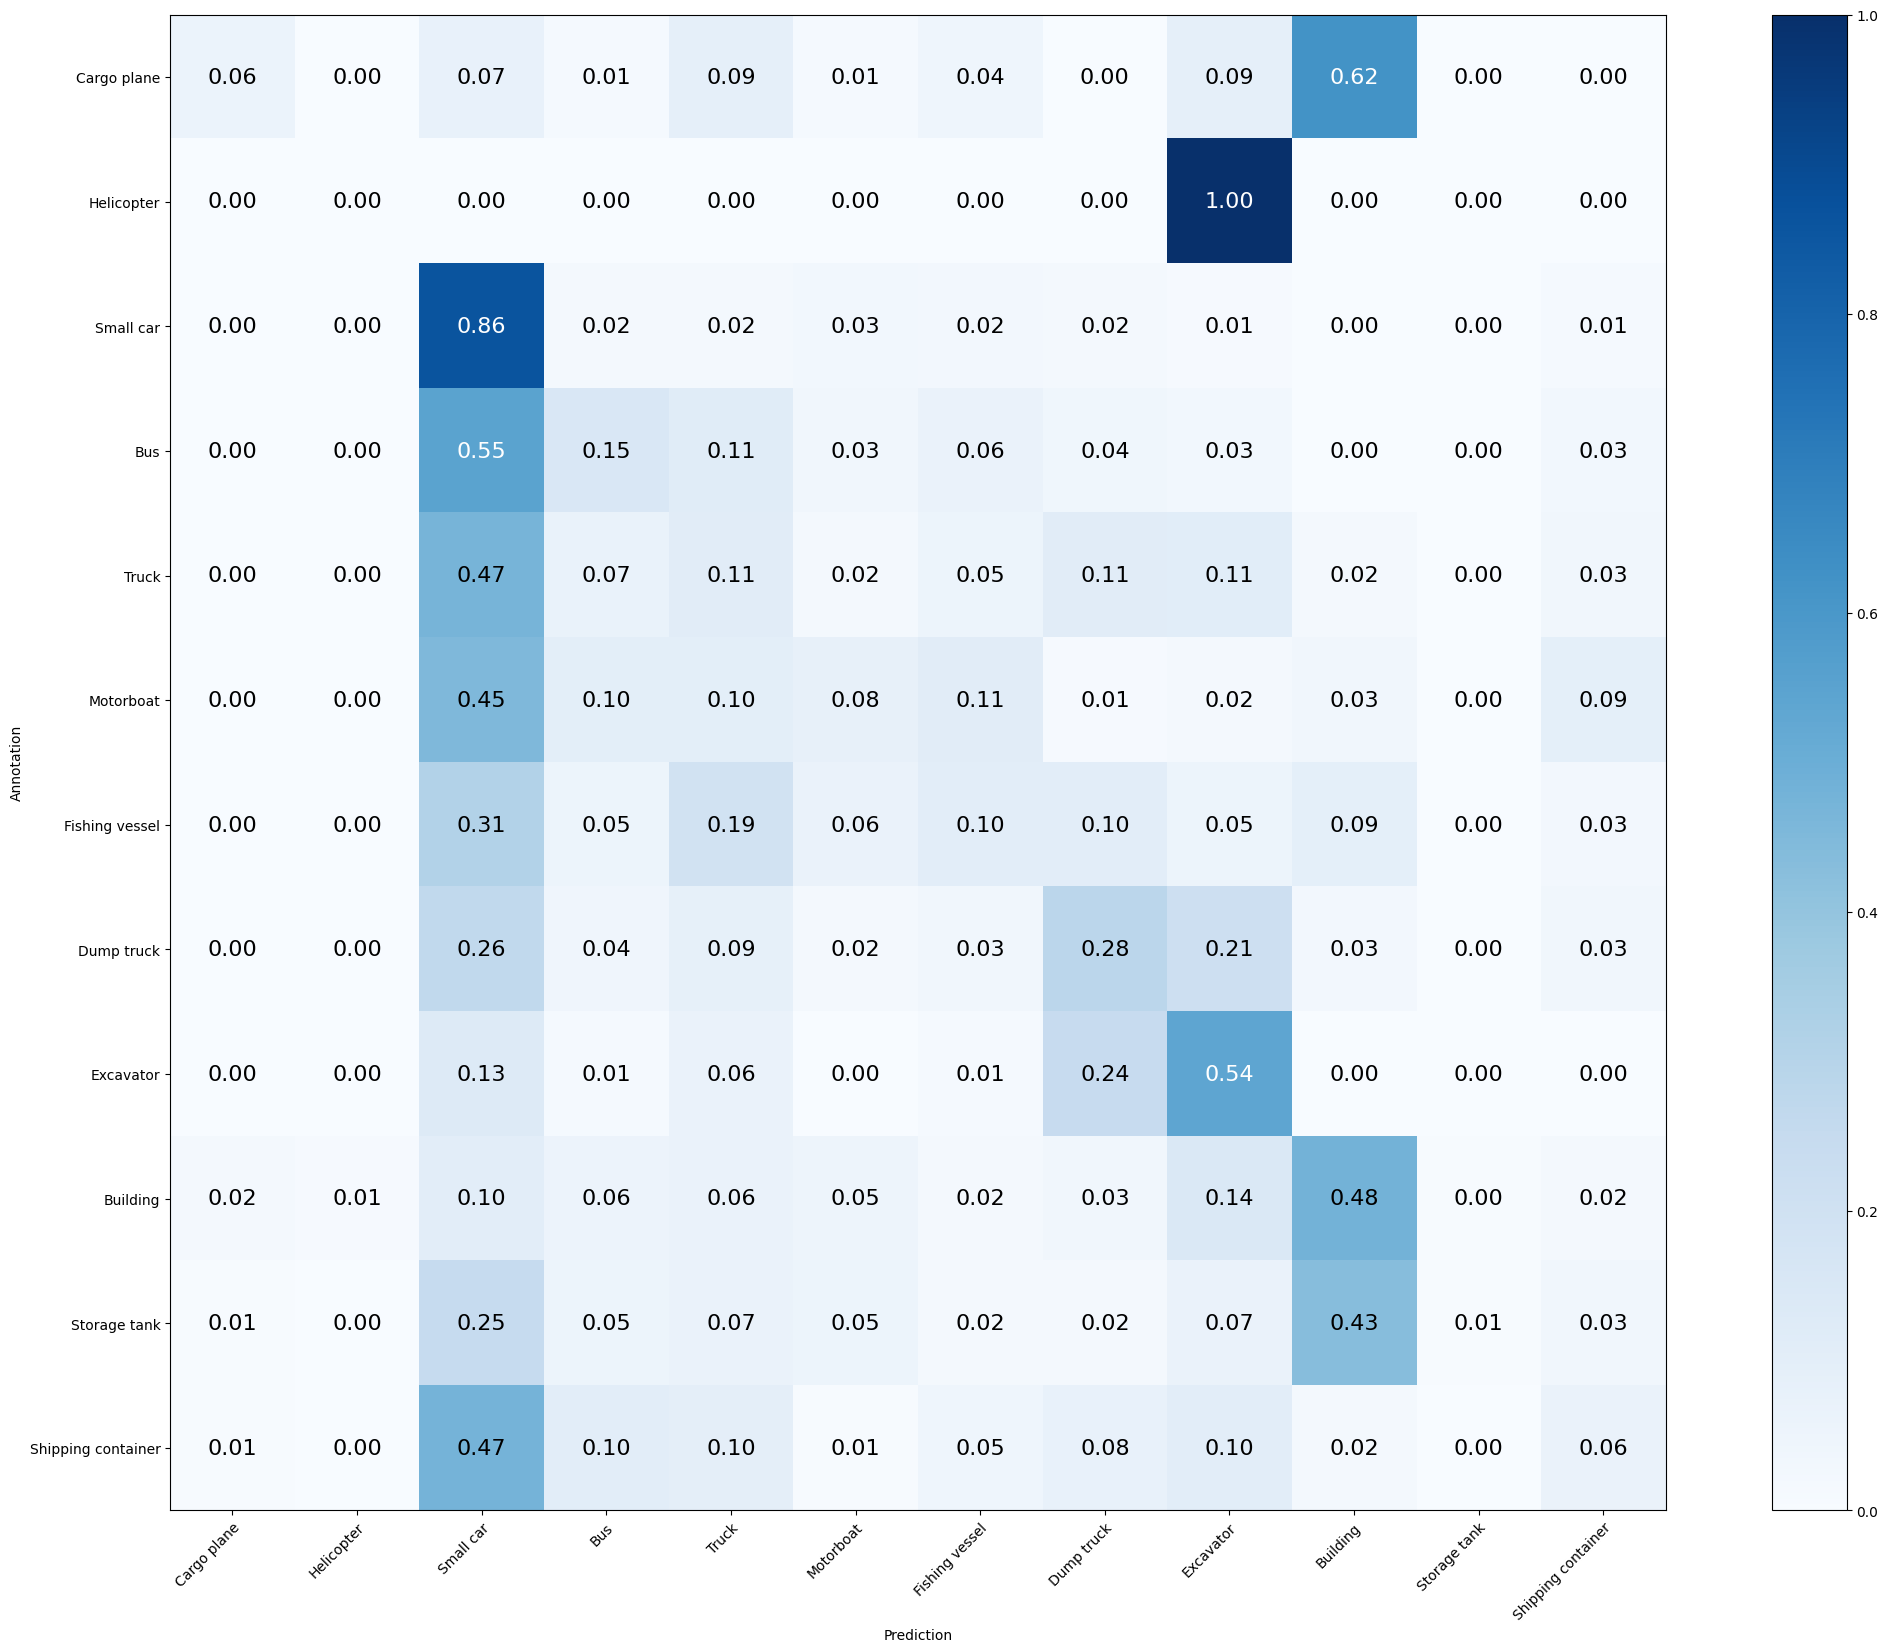

Mean Accuracy: 35.921%
Mean Recall: 22.825%
Mean Precision: 23.210%
> Cargo plane: Recall: 5.882% Precision: 25.000% Specificity: 99.420% Dice: 9.524%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 99.813% Dice: 0.000%
> Small car: Recall: 86.190% Precision: 41.136% Specificity: 69.849% Dice: 55.692%
> Bus: Recall: 15.068% Precision: 25.385% Specificity: 94.945% Dice: 18.911%
> Truck: Recall: 11.321% Precision: 18.293% Specificity: 92.846% Dice: 13.986%
> Motorboat: Recall: 7.865% Precision: 9.459% Specificity: 96.730% Dice: 8.589%
> Fishing vessel: Recall: 10.390% Precision: 9.524% Specificity: 96.312% Dice: 9.938%
> Dump truck: Recall: 28.205% Precision: 23.741% Specificity: 94.755% Dice: 25.781%
> Excavator: Recall: 53.846% Precision: 19.535% Specificity: 91.602% Dice: 28.669%
> Building: Recall: 47.984% Precision: 64.499% Specificity: 92.022% Dice: 55.029%
> Storage tank: Recall: 0.654% Precision: 25.000% Specificity: 99.849% Dice: 1.274%
> Shipping container: Recall: 

<ipython-input-21-39df9ea0fe34>:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap('Blues'))


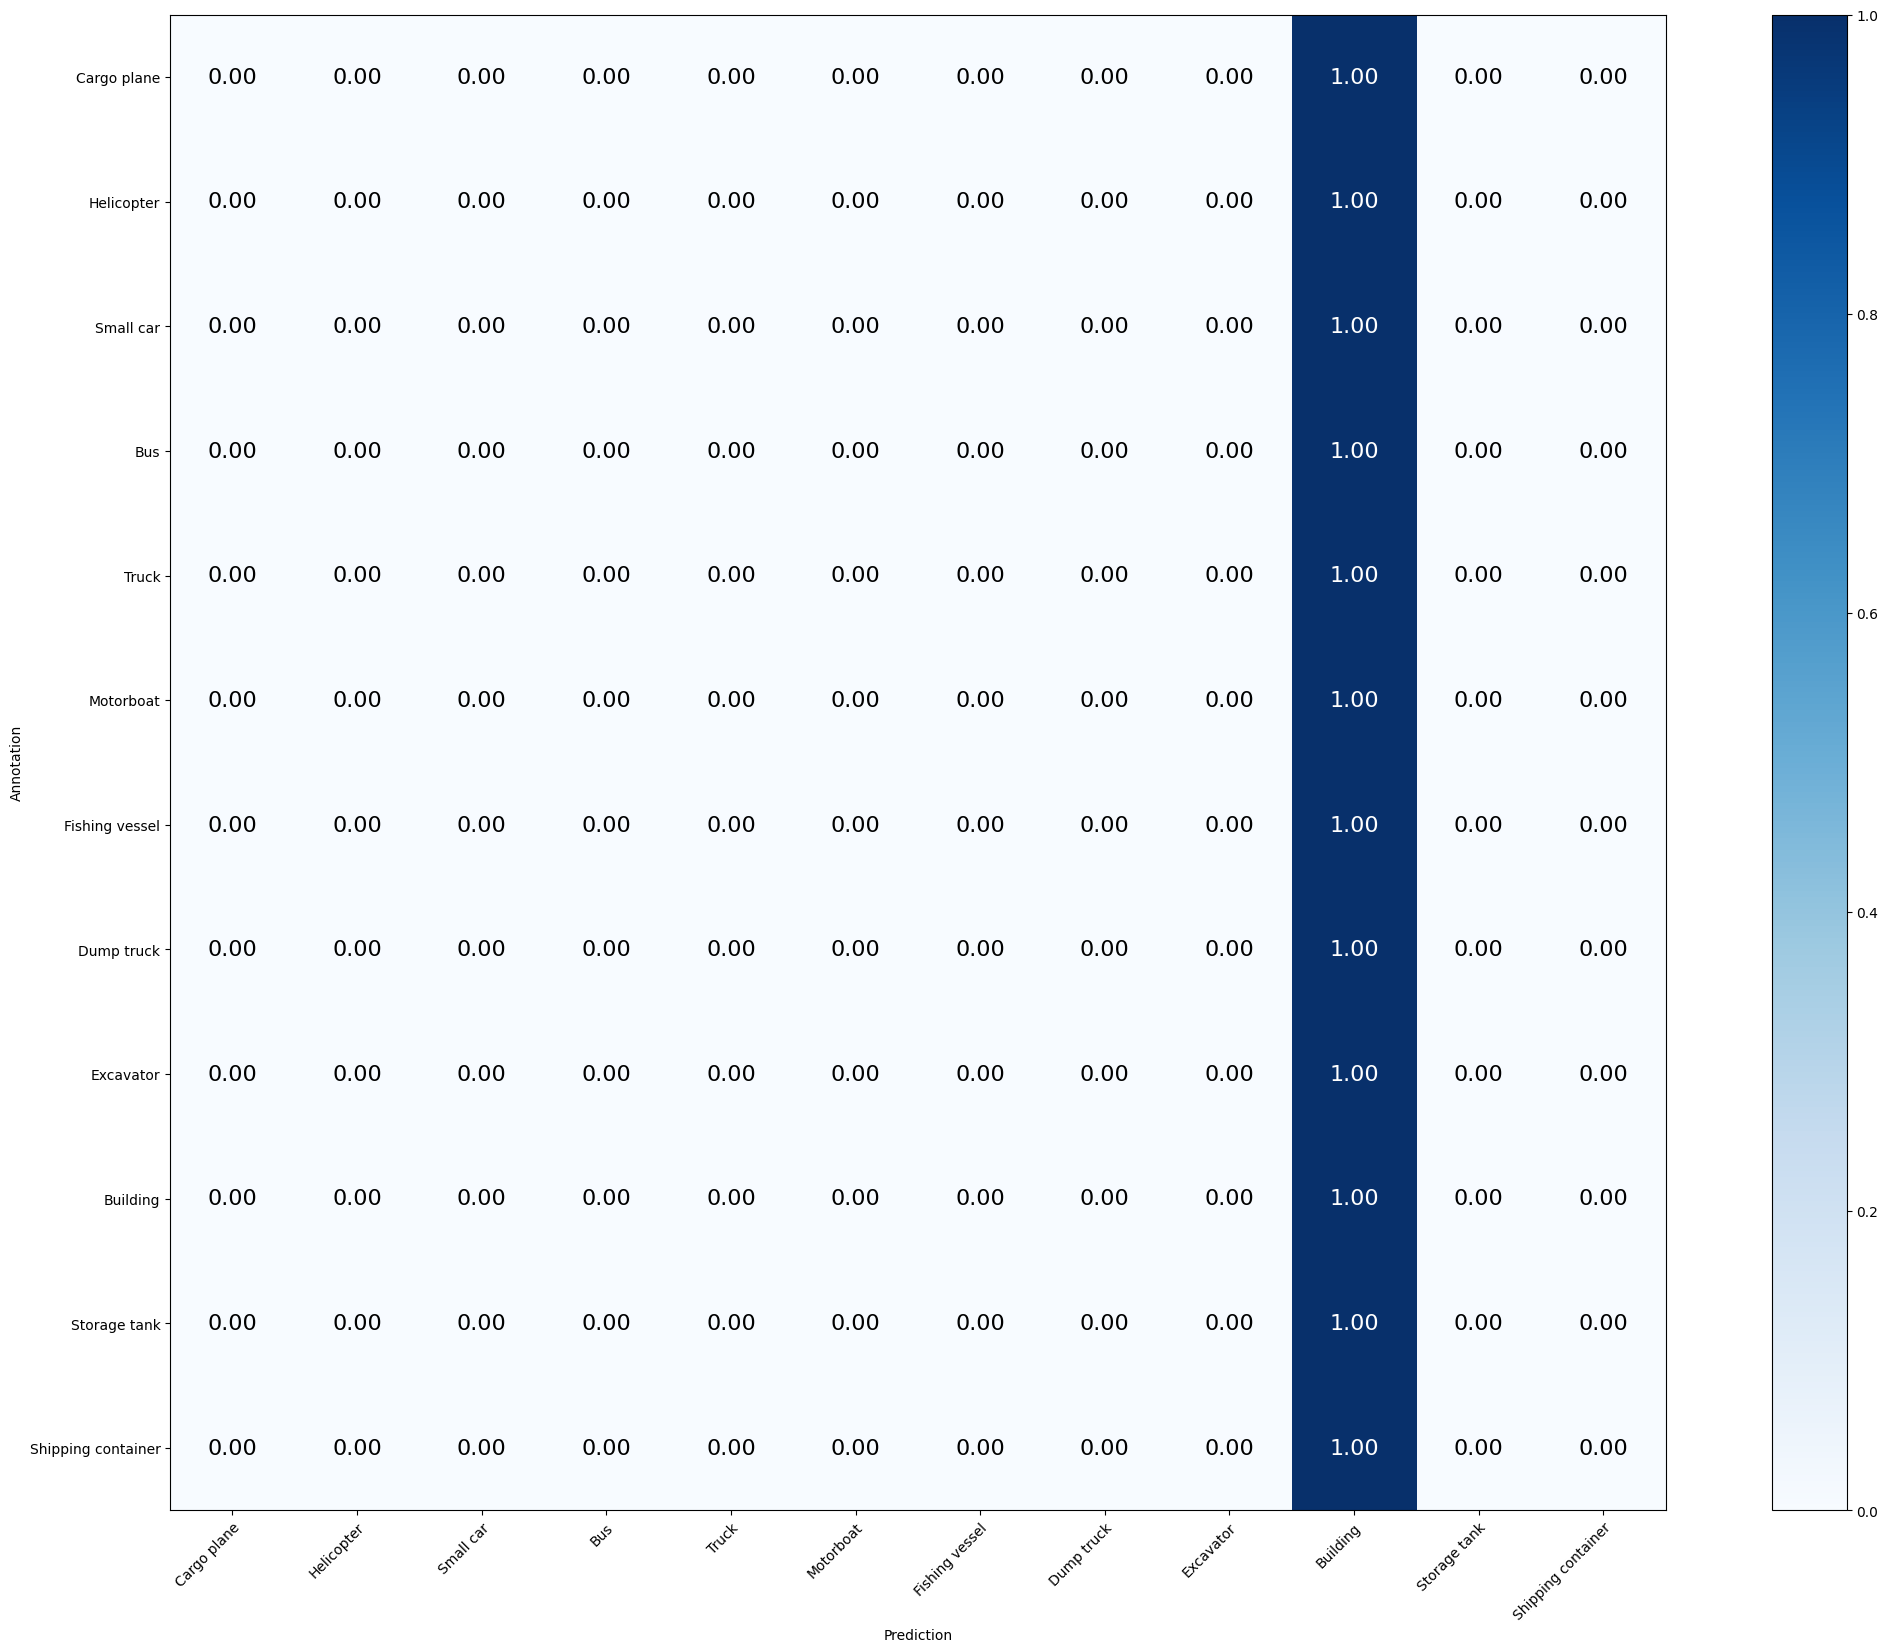

Mean Accuracy: 23.199%
Mean Recall: 8.333%
Mean Precision: 1.933%
> Cargo plane: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Helicopter: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Small car: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Bus: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Truck: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Motorboat: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Fishing vessel: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Dump truck: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Excavator: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Building: Recall: 100.000% Precision: 23.199% Specificity: 0.000% Dice: 37.661%
> Storage tank: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Shipping container: Recall: 0.000% Pre

In [24]:
import numpy as np

counter=0
for a_model in [model_1,model_2,model_3,model_4]:
    model=a_model
    num=counter+1
    model.load_weights('/kaggle/working/model_'+str(num)+'.keras')
    y_true, y_pred = [], []
    for ann in anns_valid:
        # Load image
        image = load_geoimage(ann.filename)
        for obj_pred in ann.objects:
            # Generate prediction
            warped_image = np.expand_dims(image, 0)
            predictions = model.predict(warped_image, verbose=0)
            # Save prediction
            pred_category = list(categories.values())[np.argmax(predictions)]
            pred_score = np.max(predictions)
            y_true.append(obj_pred.category)
            y_pred.append(pred_category)
    from sklearn.metrics import confusion_matrix
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
    draw_confusion_matrix(cm, categories)

    import numpy as np
    
    # Compute the accuracy
    correct_samples_class = np.diag(cm).astype(float)
    total_samples_class = np.sum(cm, axis=1).astype(float)
    total_predicts_class = np.sum(cm, axis=0).astype(float)
    print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
    acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
    print('Mean Recall: %.3f%%' % (acc.mean() * 100))
    acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
    print('Mean Precision: %.3f%%' % (acc.mean() * 100))
    for idx in range(len(categories)):
        # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
        # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
        tp = cm[idx, idx]
        fp = sum(cm[:, idx]) - tp
        fn = sum(cm[idx, :]) - tp
        tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
        # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
        recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
        # Precision: proportion of predicted positive cases that were truly real positives.
        precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
        # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
        specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
        # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
        # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
        f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
        print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))
    
    import os
    import numpy as np
    
    anns = []
    for (dirpath, dirnames, filenames) in os.walk(base_dir+'xview_test'):
        for filename in filenames:
            image = GenericImage('xview_test/'+filename)
            image.tile = np.array([0, 0, 224, 224])
            obj = GenericObject()
            obj.bb = (0, 0, 224, 224)
            obj.category = dirpath[dirpath.rfind('/')+1:]
            image.add_object(obj)
            anns.append(image)
    print('Number of testing images: ' + str(len(anns)))
    
    import numpy as np
    
    model.load_weights('/kaggle/working/model_'+str(num)+'.keras')
    predictions_data = {"images": {}, "annotations": {}}
    for idx, ann in enumerate(anns):
        image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
        predictions_data["images"][idx] = image_data
        # Load image
        image = load_geoimage(ann.filename)
        for obj_pred in ann.objects:
            # Generate prediction
            warped_image = np.expand_dims(image, 0)
            predictions = model.predict(warped_image, verbose=0)
            # Save prediction
            pred_category = list(categories.values())[np.argmax(predictions)]
            pred_score = np.max(predictions)
            annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
            predictions_data["annotations"][idx] = annotation_data
    
    with open("/kaggle/working/prediction_model"+str(counter)+".json", "w") as outfile:
        json.dump(predictions_data, outfile)

    counter+=1

In [ ]:
# import numpy as np

# # Compute the accuracy
# correct_samples_class = np.diag(cm).astype(float)
# total_samples_class = np.sum(cm, axis=1).astype(float)
# total_predicts_class = np.sum(cm, axis=0).astype(float)
# print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
# acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
# print('Mean Recall: %.3f%%' % (acc.mean() * 100))
# acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
# print('Mean Precision: %.3f%%' % (acc.mean() * 100))
# for idx in range(len(categories)):
#     # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
#     # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
#     tp = cm[idx, idx]
#     fp = sum(cm[:, idx]) - tp
#     fn = sum(cm[idx, :]) - tp
#     tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
#     # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
#     recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
#     # Precision: proportion of predicted positive cases that were truly real positives.
#     precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
#     # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
#     specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
#     # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
#     # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
#     f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
#     print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

#### Testing
Try to improve the results provided in the competition.

In [ ]:
# import os
# import numpy as np

# anns = []
# for (dirpath, dirnames, filenames) in os.walk(base_dir+'xview_test'):
#     for filename in filenames:
#         image = GenericImage('xview_test/'+filename)
#         image.tile = np.array([0, 0, 224, 224])
#         obj = GenericObject()
#         obj.bb = (0, 0, 224, 224)
#         obj.category = dirpath[dirpath.rfind('/')+1:]
#         image.add_object(obj)
#         anns.append(image)
# print('Number of testing images: ' + str(len(anns)))



In [ ]:
# import numpy as np

# model.load_weights('/kaggle/working/model.keras')
# predictions_data = {"images": {}, "annotations": {}}
# for idx, ann in enumerate(anns):
#     image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
#     predictions_data["images"][idx] = image_data
#     # Load image
#     image = load_geoimage(ann.filename)
#     for obj_pred in ann.objects:
#         # Generate prediction
#         warped_image = np.expand_dims(image, 0)
#         predictions = model.predict(warped_image, verbose=0)
#         # Save prediction
#         pred_category = list(categories.values())[np.argmax(predictions)]
#         pred_score = np.max(predictions)
#         annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
#         predictions_data["annotations"][idx] = annotation_data

In [ ]:
# with open("/kaggle/working/prediction.json", "w") as outfile:
#     json.dump(predictions_data, outfile)



In [ ]:
predictions_data